# Convolutional Neural Networks
You should build an end-to-end machine learning pipeline using a convolutional neural network model. In particular, you should do the following:
- Load the `mnist` dataset using [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). You can find this dataset in the datasets folder.
- Split the dataset into training and test sets using [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
- Build an end-to-end machine learning pipeline, including a [convolutional neural network](https://keras.io/examples/vision/mnist_convnet/) model.
- Optimize your pipeline by validating your design decisions.
- Test the best pipeline on the test set and report various [evaluation metrics](https://scikit-learn.org/0.15/modules/model_evaluation.html).  
- Check the documentation to identify the most important hyperparameters, attributes, and methods of the model. Use them in practice.

In [1]:
import os, math, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 0) Reproducibility

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

1) Load data with Pandas

In [4]:
CSV_PATH = "/content/mnist.csv"
df = pd.read_csv(CSV_PATH)

In [5]:
assert "class" in df.columns, "Expected a 'class' column as the label."
if "id" in df.columns:
    df = df.drop(columns=["id"])

In [6]:
X = df.drop(columns=["class"]).astype(np.float32).values
y = df["class"].astype(np.int64).values

# Normalize to [0,1] and reshape to (28,28,1)

In [7]:
X = (X / 255.0).reshape(-1, 28, 28, 1)

2) Train / Test split (and Validation split from train)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=SEED
)
num_classes = len(np.unique(y))

In [10]:
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (775, 28, 28, 1), Val: (137, 28, 28, 1), Test: (229, 28, 28, 1)


3) Data augmentation (lightweight, built into the model)

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.05, fill_mode="nearest"),
        layers.RandomTranslation(0.05, 0.05, fill_mode="nearest"),
        layers.RandomZoom(0.05),
    ],
    name="augmentation",
)

4) Model builder (two variants to validate design choices)

In [12]:
def build_cnn(filters=(32, 64), dense_units=128, dropout=0.3, kernel_size=3, lr=1e-3):
    inputs = keras.Input(shape=(28, 28, 1))
    x = data_augmentation(inputs)
    x = layers.Conv2D(filters[0], kernel_size, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters[0], kernel_size, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(filters[1], kernel_size, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters[1], kernel_size, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

candidates = [
    {"name": "SmallCNN", "filters": (32, 64), "dense_units": 128, "dropout": 0.3, "kernel_size": 3, "lr": 1e-3},
    {"name": "MidCNN",   "filters": (64,128), "dense_units": 256, "dropout": 0.4, "kernel_size": 3, "lr": 8e-4},
]

5) Training setup with validation (EarlyStopping + LR decay)

In [13]:
BATCH_SIZE = 128
EPOCHS = 30

def train_and_validate(config):
    model = build_cnn(
        filters=config["filters"],
        dense_units=config["dense_units"],
        dropout=config["dropout"],
        kernel_size=config["kernel_size"],
        lr=config["lr"],
    )

    callbacks = [
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-5, monitor="val_loss"),
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=2,
        callbacks=callbacks,
    )
    # Best validation accuracy
    best_val_acc = max(history.history["val_accuracy"])
    return model, history, best_val_acc

histories = {}
models = {}
val_scores = {}

for cfg in candidates:
    print(f"\n=== Training {cfg['name']} ===")
    model, history, best_acc = train_and_validate(cfg)
    histories[cfg["name"]] = history
    models[cfg["name"]] = model
    val_scores[cfg["name"]] = best_acc
    print(f"{cfg['name']} best val acc: {best_acc:.4f}")

best_name = max(val_scores, key=val_scores.get)
best_model = models[best_name]
print(f"\nSelected best model: {best_name} (val_acc={val_scores[best_name]:.4f})")


=== Training SmallCNN ===
Epoch 1/30
7/7 - 8s - 1s/step - accuracy: 0.0916 - loss: nan - val_accuracy: 0.0949 - val_loss: nan - learning_rate: 1.0000e-03
Epoch 2/30
7/7 - 3s - 443ms/step - accuracy: 0.0916 - loss: nan - val_accuracy: 0.0949 - val_loss: nan - learning_rate: 1.0000e-03
Epoch 3/30
7/7 - 5s - 678ms/step - accuracy: 0.0916 - loss: nan - val_accuracy: 0.0949 - val_loss: nan - learning_rate: 5.0000e-04
Epoch 4/30
7/7 - 3s - 395ms/step - accuracy: 0.0916 - loss: nan - val_accuracy: 0.0949 - val_loss: nan - learning_rate: 5.0000e-04
Epoch 5/30
7/7 - 5s - 727ms/step - accuracy: 0.0916 - loss: nan - val_accuracy: 0.0949 - val_loss: nan - learning_rate: 2.5000e-04
Epoch 6/30
7/7 - 5s - 731ms/step - accuracy: 0.0916 - loss: nan - val_accuracy: 0.0949 - val_loss: nan - learning_rate: 2.5000e-04
SmallCNN best val acc: 0.0949

=== Training MidCNN ===
Epoch 1/30
7/7 - 12s - 2s/step - accuracy: 0.0916 - loss: nan - val_accuracy: 0.0949 - val_loss: nan - learning_rate: 8.0000e-04
Epoch 

6) Plot learning curves for the best model

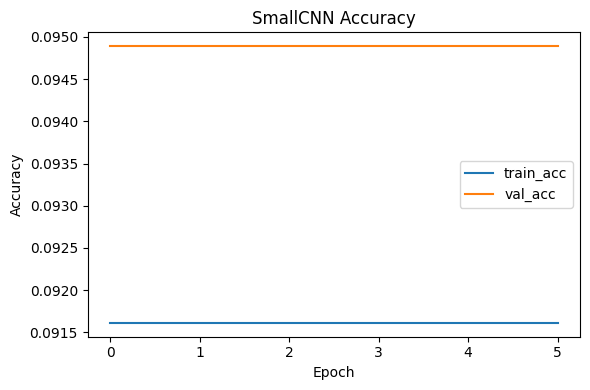

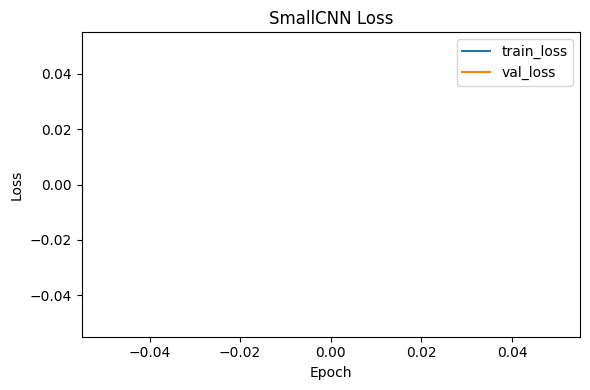

In [15]:
def plot_history(h):
    plt.figure(figsize=(6,4))
    plt.plot(h.history["accuracy"], label="train_acc")
    plt.plot(h.history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{best_name} Accuracy")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(h.history["loss"], label="train_loss")
    plt.plot(h.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{best_name} Loss")
    plt.legend(); plt.tight_layout(); plt.show()

plot_history(histories[best_name])

7) Evaluate on the test set (metrics)


Test Accuracy: 0.0917
Test F1 (macro): 0.0168

Classification Report:
               precision    recall  f1-score   support

           0     0.0917    1.0000    0.1680        21
           1     0.0000    0.0000    0.0000        25
           2     0.0000    0.0000    0.0000        23
           3     0.0000    0.0000    0.0000        22
           4     0.0000    0.0000    0.0000        20
           5     0.0000    0.0000    0.0000        24
           6     0.0000    0.0000    0.0000        20
           7     0.0000    0.0000    0.0000        26
           8     0.0000    0.0000    0.0000        24
           9     0.0000    0.0000    0.0000        24

    accuracy                         0.0917       229
   macro avg     0.0092    0.1000    0.0168       229
weighted avg     0.0084    0.0917    0.0154       229



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


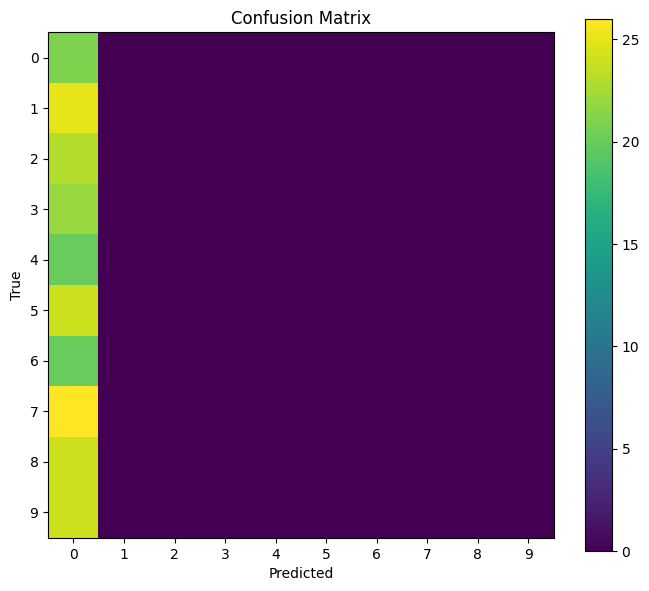

In [16]:
test_probs = best_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = np.argmax(test_probs, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test F1 (macro): {f1_macro:.4f}\n")

print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks); plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

What’s being “validated” (optimization choices)

Two architecture sizes are trained; the one with higher val accuracy is selected.

EarlyStopping prevents overfitting; ReduceLROnPlateau adapts the learning rate.

Light augmentation improves generalization without heavy training cost.